### Quantifying Model Fit

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols 

##### The Coefficient of Determination 

R-squared ('r' for single and 'R' for multiple explanatory variables) is the proportion of variance in the response variable that is predictable from the explanatory variable. The range is [0,1]; 1 for perfect fit 0 for worst possible fit.

In simpler terms, the coefficient of determination is simply the correlation between the explanatory and the response variable squared.

##### Residual Standard Error (RSE)

RSE is the 'typical' residual value of observed and predicted datapoints. It can also be viewed as the standard deviation of the residuals in a linear regression model. Since it is an SD, it has the same unit as the response variable. Als note that Mean Squared Error (MSE) is equal to the square of the RSE. MSE = RSE^2. 

In [2]:
# Going back to the fish dataset

fish = pd.read_csv('Data/fish.csv')
fish.head()

,species,mass_g,length_cm
0,Bream,242.0,23.2
1,Bream,290.0,24.0
2,Bream,340.0,23.9
3,Bream,363.0,26.3
4,Bream,430.0,26.5


In [3]:
bream = fish[fish['species'] == 'Bream']

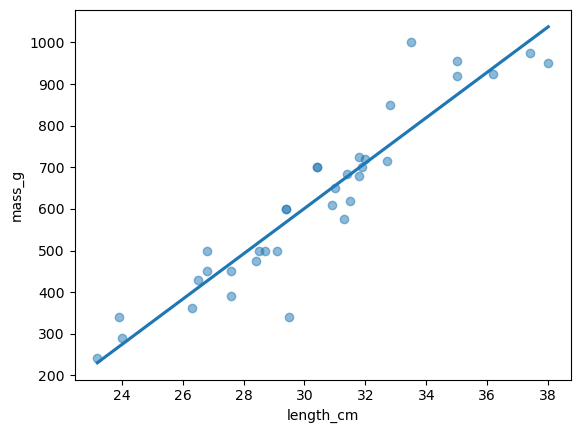

In [4]:
sns.regplot(
    x='length_cm',
    y='mass_g',
    data=bream,
    ci=None,
    scatter_kws={'alpha':0.5}
)

plt.show()

In [5]:
# Creating the model 
mdl_bream_length_vs_mass = ols('mass_g ~ length_cm', data=bream).fit()

mdl_bream_length_vs_mass.rsquared

0.8780627095147174

As shown above, an r^2 of 0.88 indicates that the model explains about 88% of the variability in the mass of breams.

In [6]:
# Calculating RSS
resid_diffs = mdl_bream_length_vs_mass.resid ** 2
rss = resid_diffs.sum()
rss

181452.31780412616

In [7]:
# Calculating RSE
rss_div_dof = rss / (resid_diffs.shape[0] - 2)
rse = round(np.sqrt(rss_div_dof), 2)
rse


74.15

This RSE value suggests that the typical difference between the observed masses and predicted masses is about 74.15.

In [8]:
# Getting MSE from RSE
mse = rse ** 2
round(mse, 2)
# Note that there is a straightforward way of getting MSE 
#using .mse_resid attribute

5498.22

In [9]:
exp_data = pd.DataFrame({'length_cm':np.arange(28, 36, 2)})

bream_predict = exp_data.assign(
    predicted_mass_g=mdl_bream_length_vs_mass.predict(exp_data)
)

bream_predict

,length_cm,predicted_mass_g
0,28,492.051901
1,30,601.151863
2,32,710.251825
3,34,819.351787


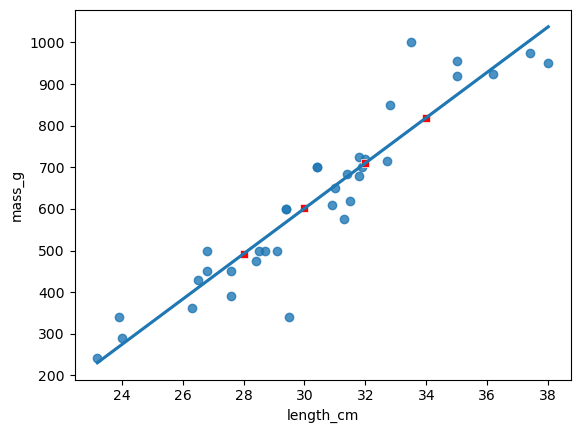

In [10]:
fig = plt.figure()

sns.regplot(
    x='length_cm',
    y='mass_g',
    data=bream,
    ci=None
)

sns.scatterplot(
    x='length_cm',
    y='predicted_mass_g',
    data=bream_predict,
    color='r',
    marker='s'
)

plt.show()

### Visualizing Model Fit and Characteristics of Good-Fitting Model

A good-fit model is said to have:
- normally distributed residuals; and
- a residual mean equal to zero

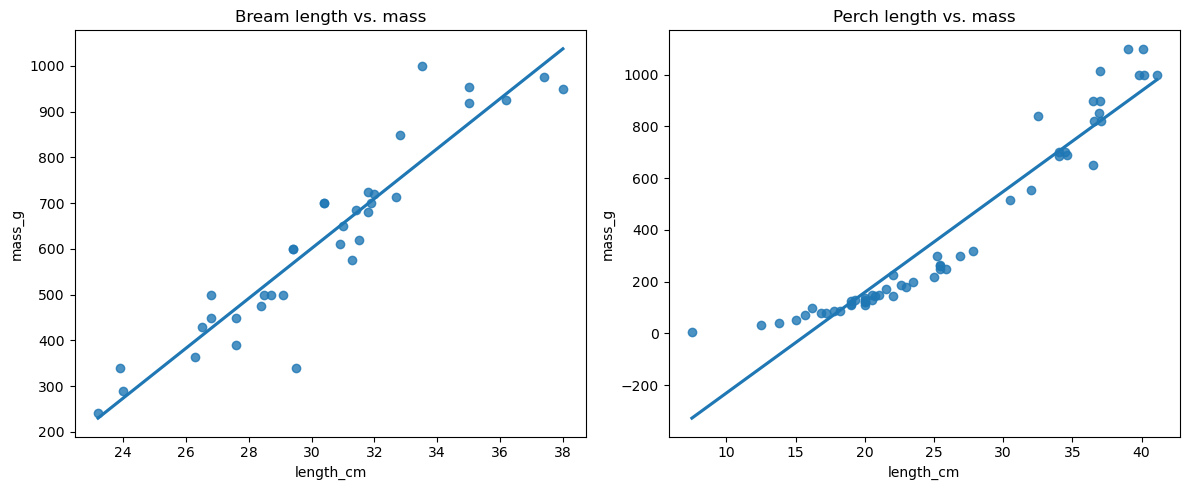

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.regplot(
    x='length_cm',
    y='mass_g',
    data=bream,
    ci=None,
    ax=ax[0]
)

ax[0].set_title('Bream length vs. mass')

sns.regplot(
    x='length_cm',
    y='mass_g',
    data=fish[fish['species'] == 'Perch'],
    ci=None,
    ax=ax[1]
)

ax[1].set_title('Perch length vs. mass')

plt.tight_layout()
plt.show()

Observe the difference between the two plots. Notice the good fit on the bream dataset's datapoints. The perch model, on the other hand, fitted poorly because the masses exhibited a faster, non-linear increase for low length values.

##### LOWESS Trendline

LOWESS stands for 'Locally Weighted Scatterplot Smoothing'. This type of plot simply fits a simple regression line in a local area of an independent variable *x* for all *x*. These local regression are then used to predict the smoothed value for *x*. The plot interpretation is relatively straightforward; it seeks to answer the question, "On average, are my errors centered around zero across all predicted values?".

- If the trendline is **FLAT** or the data is around zero, this means that the model captures the relationship well and that residuals are but just random noise.
- If the trendline is **CURVED** or **SLOPED**, this means that the model deviates from zero and means that you have fitted a straight line onto curved data.
- If the trendline shows **SHIFTS ABOVE/BELOW ZERO** at different fitted values, it may indicate model bias or non-linearity.

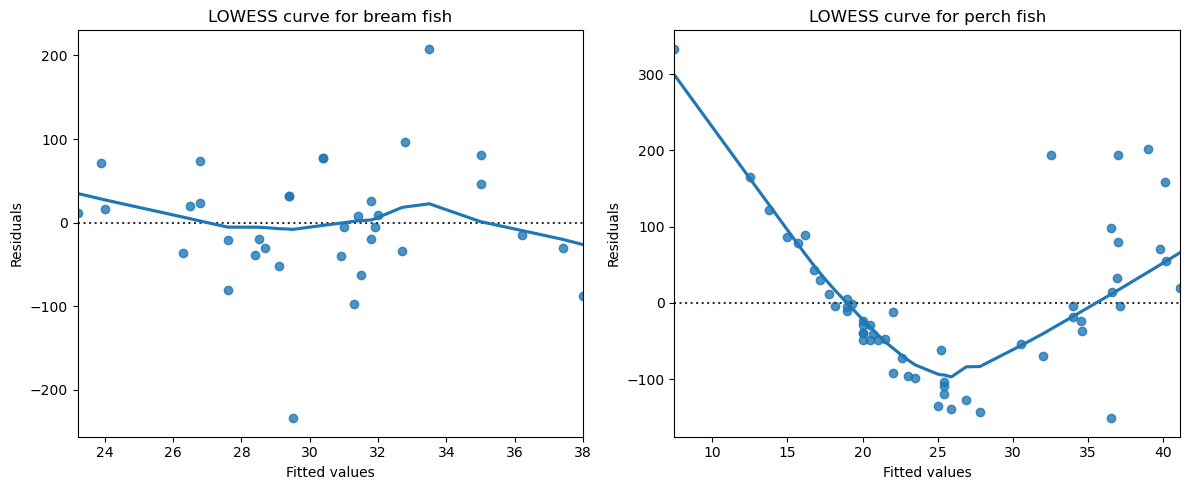

In [24]:
perch = fish[fish['species'] == 'Perch']

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.residplot(
    x='length_cm',
    y='mass_g',
    data=bream,
    lowess=True,
    ax=ax[0]
)

ax[0].set_title('LOWESS curve for bream fish')
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Residuals')

sns.residplot(
    x='length_cm',
    y='mass_g',
    data=perch,
    lowess=True,
    ax=ax[1]
)

ax[1].set_title('LOWESS curve for perch fish')
ax[1].set_xlabel('Fitted values')
ax[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

##### Q-Q Plot

A Quantile-Quantile Plot is another diagnostic plot that is used to visualize whether certain data follows the theoretical normal distribution. It simply plots the quantiles of the normal distribution against the sample data. If the points lie close to the line y=x, then the data is assumed to be drawn from the normal distribution.

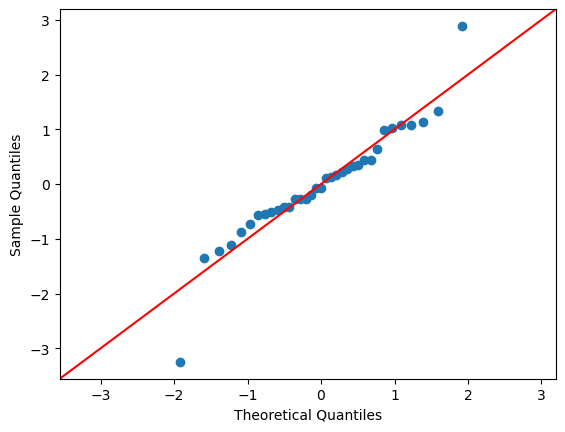

In [ ]:
# A Q-Q plot can be made using the qqplot method from statsmodels.api

from statsmodels.api import qqplot

qqplot(
    data=mdl_bream_length_vs_mass.resid,     # pass residuals as they are the data of interest
    fit=True,                               # set fit=True to denote comparison to normal distribution
    line='45'                               # 45-deg line for y=x
)

plt.show()

##### Scale-Location Plot

A scale-location plot visualizes the homoscedasticity assumption, or the assumption that the residuals exhibit constant variance for all predictor variables *x*. The x-axis represents fitted values while the y-axis represents the square root of the absolute value of the residuals. In short, this plot shows whether a particular model's error gets bigger or smaller as predictions change. 

- If the residuals have **Constant Spread**, or exhibits a flat horizontal band, across all fitted values, the variance is constant.
- If the plot shows an **Upward/Downward Trend**, the variance increases as fitted values increase/decrease.

**Below are the steps to follow in order to create a scale-location plot in a statsmodels-implemented linear regression model:**

1. Extract normalized residuals from the model using the `get_influence()` method and accessing the `resid_studentized_internal` attribute of the model.


In [36]:
bream_mdl_norm_resids = mdl_bream_length_vs_mass.get_influence().resid_studentized_internal

2. Take the square root of the absolute value of the normalized residuals to standardize them.

In [37]:
bream_mdl_std_resids = np.sqrt(np.abs(bream_mdl_norm_resids))

3. Plot the fitted values against the standardized residuals.

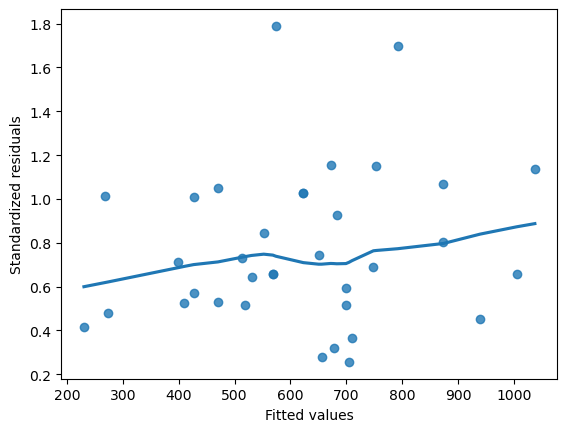

In [40]:
sns.regplot(
    x=mdl_bream_length_vs_mass.fittedvalues,
    y=bream_mdl_std_resids,
    ci=None,
    lowess=True       # Set lowess=True for scatterplot smoothing and make interpretation easier
)

plt.xlabel('Fitted values')
plt.ylabel('Standardized residuals')
plt.show()